# Проект "Выявление профилей потребления (E-commerce)"

Цель проекта: сегментировать пользователей, чтобы выдвинуть персонализированные предложения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('ecommerce_dataset.csv')

## Предобработка данных

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


 Изменим типы данных в столбцах *date* и *price*. Создадим столбец *total_price*, в котором будет итоговая стоимость.

In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
data['month'] = data['date'].astype('datetime64[M]')
data['month_number'] = data['date'].dt.month
data['price'] = data['price'].astype(int)
data['total_price'] = data['price'] * data['quantity']

Проверим на пропуски.

In [5]:
data.isna().sum()

date            0
customer_id     0
order_id        0
product         0
quantity        0
price           0
month           0
month_number    0
total_price     0
dtype: int64

Проверим на дубликаты.

In [6]:
data.duplicated().sum()

0

Открытых дубликатов нет, проверим на скрытые дубликаты:

In [7]:
data.duplicated(subset = ['customer_id','order_id', 'product']).sum()

1886

Поскольку оператор БД сказал, что эти дубликаты нужно беспощадно удалить, так и сделаем.

In [8]:
data = data.drop_duplicates(subset = ['customer_id','order_id', 'product'])

Наконец, проверим на пропуски:

In [9]:
data.isna().sum()

date            0
customer_id     0
order_id        0
product         0
quantity        0
price           0
month           0
month_number    0
total_price     0
dtype: int64

Пропусков нет. Переходим к следующему шагу.

## Исследовательский анализ данных

Последовательность шагов на этом этапе:
- Найти общее количество покупателей, общее количество товаров, среднюю выручку, среднее количество покупаемых товаров, средную сумму заказов;
- Построить графики с динамикой продаж и количества покупателей;
- Построить графики с суммой продаж и количеством покупателей по месяцам.

### Найдём общее количество покупателей, общее количество товаров, среднюю выручку, среднее количество покупаемых товаров, средную сумму заказов

In [10]:
print('Количество уникальных пользователей: {}'.format(data['customer_id'].nunique()))
print('Количество уникальных товаров: {}'.format(data['product'].nunique()))
print('Средняя выручка за весь период: {} руб.'.format(data['total_price'].median()))

Количество уникальных пользователей: 2451
Количество уникальных товаров: 2343
Средняя выручка за весь период: 194.0 руб.


Построим "ящик с усами" и посмотрим, есть ли выбросы.

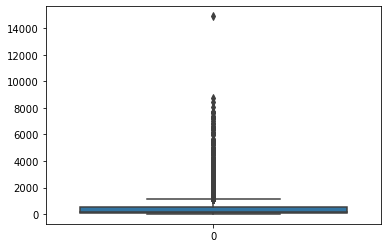

In [11]:
sns.boxplot(data=data['price'])
plt.show()

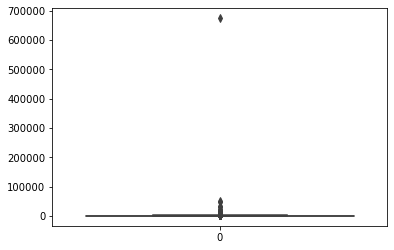

In [12]:
sns.boxplot(data=data['total_price'])
plt.show()

Есть ощутимые выбросы. Посмотрим, что нам скажут перцентили.

In [13]:
np.percentile(data['total_price'], [95, 99, 100])

array([  2849. ,   6148.5, 675000. ])

Получается, была аномально большая сумма. Посмотрим на неё поближе:

In [14]:
data[data['total_price'] == 675000]

,date,customer_id,order_id,product,quantity,price,month,month_number,total_price
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675,2019-06-01,6,675000


Очевидно, перед нами оптовик. Создадим новый датасет, в котором отбросим этот выброс.

In [15]:
data_new = data.query('total_price <=5594')
data_new

,date,customer_id,order_id,product,quantity,price,month,month_number,total_price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,2018-10-01,10,142
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194,2018-10-01,10,194
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,2018-10-01,10,112
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179,2018-10-01,10,179
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112,2018-10-01,10,112
...,...,...,...,...,...,...,...,...,...
6731,2019-10-31 11:00:00,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329,2019-10-01,10,329
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404,2019-10-01,10,404
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087,2019-10-01,10,1087
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157,2019-10-01,10,157


### Построим графики с динамикой продаж и количества покупателей

Создадим сгруппированную таблицу по числу уникальных пользователей и суммарной выручке.

In [16]:
grouped_by_date = data.groupby(['month', 'month_number']).agg({'customer_id':'nunique', 'order_id': 'nunique',
                                                               'total_price':'sum'}).reset_index()
grouped_by_date

,month,month_number,customer_id,order_id,total_price
0,2018-10-01,10,181,239,351910
1,2018-11-01,11,178,204,359348
2,2018-12-01,12,238,284,356516
3,2019-01-01,1,152,167,235432
4,2019-02-01,2,247,288,307996
5,2019-03-01,3,236,247,253589
6,2019-04-01,4,239,267,318171
7,2019-05-01,5,172,183,237955
8,2019-06-01,6,155,162,903210
9,2019-07-01,7,186,198,234932


In [17]:
data.groupby('month_number')['order_id'].nunique().reset_index()

,month_number,order_id
0,1,167
1,2,288
2,3,247
3,4,267
4,5,183
5,6,162
6,7,198
7,8,174
8,9,182
9,10,438


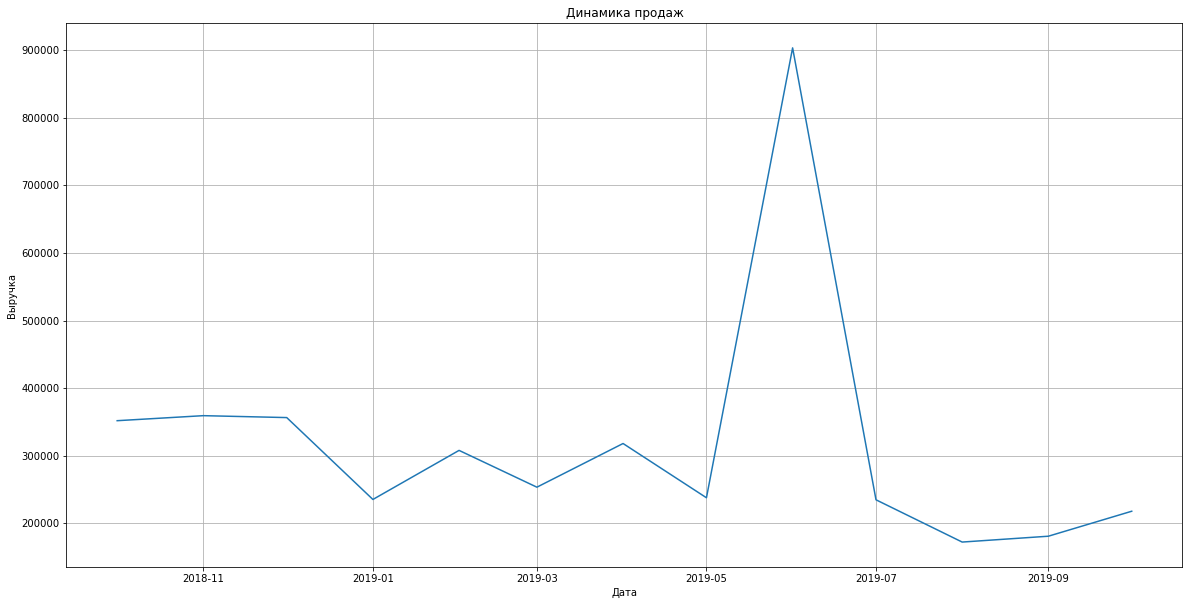

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(grouped_by_date['month'], grouped_by_date['total_price'])
plt.title('Динамика продаж')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.show()

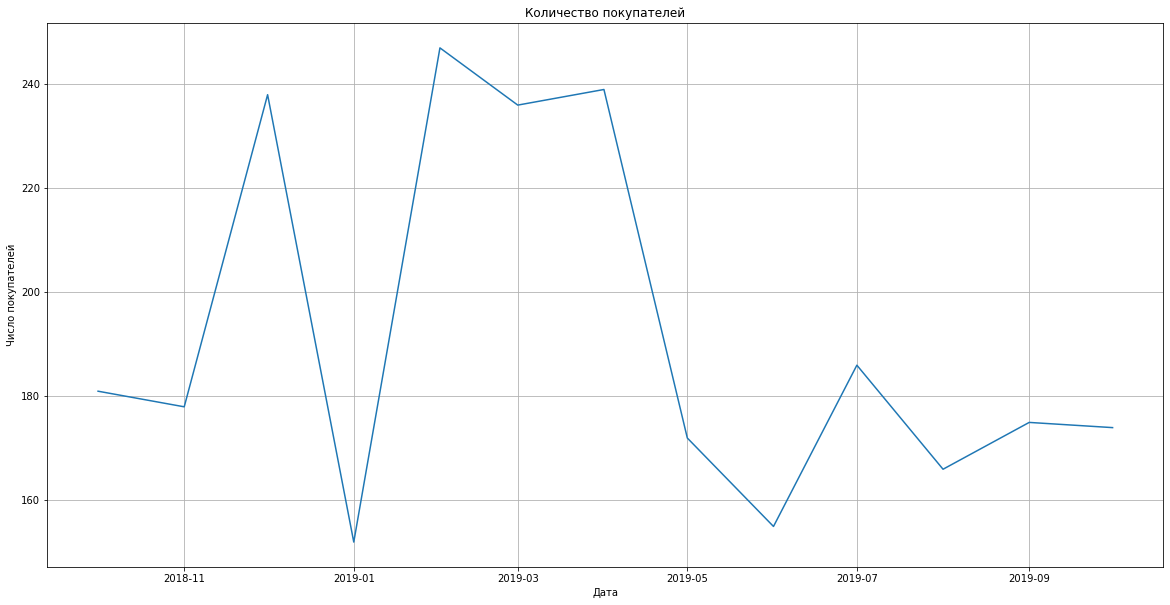

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(grouped_by_date['month'], grouped_by_date['customer_id'])
plt.title('Количество покупателей')
plt.xlabel('Дата')
plt.ylabel('Число покупателей')
plt.grid()
plt.show()

Первое, что бросается в глаза: резкий рост выручки в июне 2019 года. Примечательно, что в том же месяце наблюдается спад количества покупателей. Однозначно перед нами выброс. 

Также мы наблюдаем спад и количества покупателей, и выручки в январе - это легко объясняется посленовогодним периодом, для которого характерно затишье. 

Хотя мы видим резкий рост числа покупателей в феврале, на выручке это отражается слабо. Вероятно, имело место больше количество покупок с низким прайсом - отсюда и небольшая суммарная выручка.

Других особенностей графики не показывают.

### Построим графики с суммой продаж и количеством покупателей по месяцам

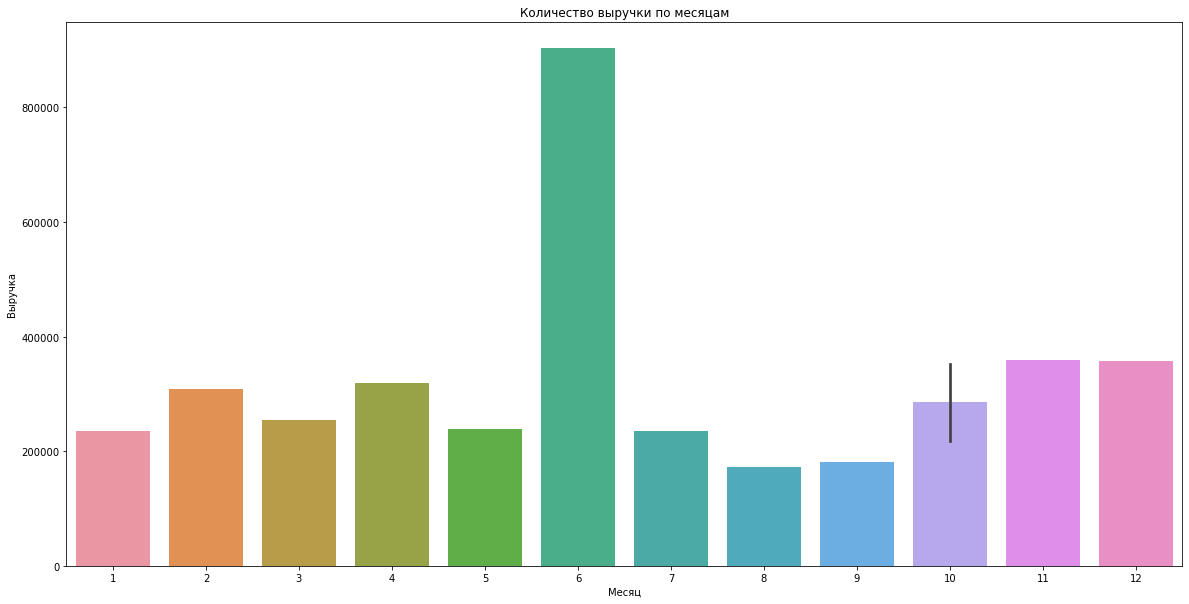

In [20]:
plt.figure(figsize=(20,10))
sns.barplot(data=grouped_by_date, x='month_number', y='total_price')
plt.title('Количество выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

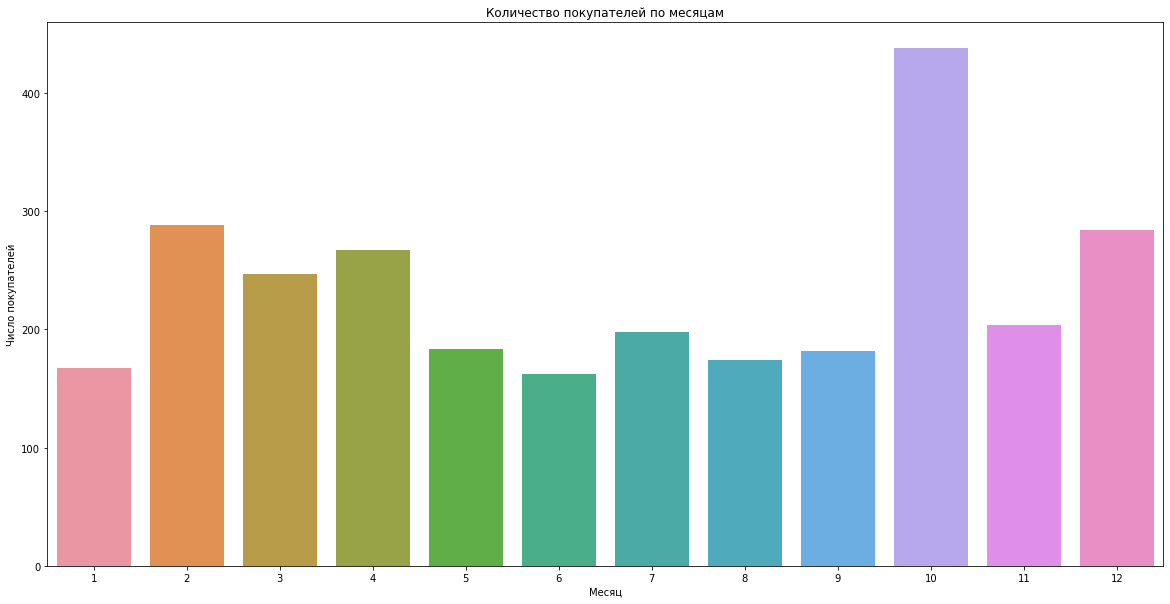

In [21]:
plt.figure(figsize=(20,10))
sns.barplot(data=data.groupby('month_number')['order_id'].nunique().reset_index(), x='month_number', y='order_id')
plt.title('Количество покупателей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число покупателей')
plt.show()

Первый график показывает ощутимый рост выручки в июне - это тот самый ранее обнаруженный выброс. Если его не учитывать, то ощутимой разницы по месяца мы не увидим. Это говорит об отсутствии сезонности (по крайней мере, на данном этапе исследования).

Второй график показывает ощутимый рост числа покупателей в октябре. Однако в действительности это иллюзия - если взглянуть на данные, то обнаруживается, что октябрь встречается дважды: в 2018 и 2019 годах.

## Категоризация товаров

Категоризацию осуществим в несколько этапов. Создадим столбец *product_first*, в который поместим первое слово в каждой строке столбца *product*. Затем методом *Counter* найдём топ-200 наиболее часто встречающихся слов в столбцах *product* и *product_first* и на их основе создадим словари с основными категориями, после чего создадим отдельный столбец, в котором каждой строке будет присвоена своя категория.

Создадим столбец *product_first* посредством функции first_word.

In [22]:
def first_word(word):
    w = word.split()
    return w[0]
data_new['product_first'] = data_new['product'].apply(first_word)
data_new.head()

,date,customer_id,order_id,product,quantity,price,month,month_number,total_price,product_first
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,2018-10-01,10,142,Комнатное
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194,2018-10-01,10,194,Комнатное
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,2018-10-01,10,112,Радермахера
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179,2018-10-01,10,179,Хризолидокарпус
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112,2018-10-01,10,112,Циперус


Теперь применим *Counter*.

In [23]:
Counter(" ".join(data_new['product'].str.lower()).split()).most_common(200)

[('см', 1962),
 ('для', 1006),
 ('пеларгония', 716),
 ('рассада', 596),
 ('в', 553),
 ('л', 473),
 ('диам.', 448),
 ('с', 383),
 ('зональная', 377),
 ('сорт', 359),
 ('укорененный', 339),
 ('черенок', 339),
 ('12', 329),
 ('махровая', 326),
 ('белья', 313),
 ('объем', 296),
 ('сушилка', 280),
 ('шт', 277),
 ('по', 260),
 ('розебудная', 249),
 ('кассете', 245),
 ('gimi', 233),
 ('0,5', 232),
 ('кухни', 225),
 ('зелени', 220),
 ('сумка-тележка', 213),
 ('6', 179),
 ('петуния', 176),
 ('9', 174),
 ('россия', 174),
 ('муляж', 173),
 ('горшке', 171),
 ('томата', 162),
 ('(помидор)', 162),
 ('ника', 158),
 ('кассета', 157),
 ('кг', 153),
 ('и', 150),
 ('цветов', 147),
 ('м', 145),
 ('4', 141),
 ('см,', 137),
 ('белая', 134),
 ('полумахровая', 133),
 ('d-7', 133),
 ('однолетних', 123),
 ('доска', 119),
 ('d12,', 117),
 ('гладильная', 117),
 ('среднеспелый', 115),
 ('синяя', 114),
 ('хозяйственная', 114),
 ('10', 111),
 ('герань', 110),
 ('домашняя', 110),
 ('(пеларгония', 110),
 ('зональная)'

In [24]:
Counter(" ".join(data_new['product_first'].str.lower()).split()).most_common(200)

[('пеларгония', 708),
 ('рассада', 467),
 ('сушилка', 275),
 ('сумка-тележка', 213),
 ('муляж', 173),
 ('томата', 142),
 ('петуния', 141),
 ('гладильная', 115),
 ('герань', 110),
 ('коврик', 105),
 ('тележка', 97),
 ('чехол', 88),
 ('штора', 76),
 ('таз', 68),
 ('однолетнее', 67),
 ('роза', 57),
 ('искусственный', 52),
 ('калибрахоа', 50),
 ('тарелка', 39),
 ('набор', 37),
 ('бакопа', 37),
 ('вешалка', 36),
 ('цветок', 35),
 ('корзина', 33),
 ('скатерть', 28),
 ('стремянка', 27),
 ('салатник', 24),
 ('мята', 22),
 ('полки', 21),
 ('подвесное', 21),
 ('чайник', 19),
 ('базилик', 19),
 ('фуксия', 19),
 ('банка', 17),
 ('флокс', 16),
 ('декабрист', 16),
 ('ёрш', 15),
 ('щетка', 15),
 ('примула', 15),
 ('вербена', 15),
 ('нож', 14),
 ('эвкалипт', 14),
 ('фиалка', 14),
 ('карниз', 14),
 ('кружка', 14),
 ('искусственная', 14),
 ('дыня', 14),
 ('лобелия', 14),
 ('сумка', 13),
 ('подкладка', 13),
 ('цикламен', 13),
 ('контейнер', 13),
 ('швабра', 13),
 ('бегония', 13),
 ('комнатное', 12),
 ('к

Выделим пять категорий:
1. home - всё для дома;
2. plant - растения;
3. bag - сумки и тележки;
4. country_house - всё для дачи;
5. seedling - рассада.

Список *plant* мы составили не только при помощи метода *Counter*, но и взяв их открытых источников список растений, предварительно обработав его в Excel. 

In [25]:
plant = [
'лавр',
'ледебурия',
'леея',
'маранта',
'мирт',
'монстера',
'мюленбекия',
'нандина',
'непентес',
'нертера',
'оплисменус',
'осока',
'офиопогон',
'палисота',
'панданус',
'паслён',
'пахира',
'пеллиония',
'пеперомия',
'перец',
'пизония',
'пилея',
'плектрантус',
'плющ',
'погонатерум',
'полисциас',
'псевдоэрантемум',
'радермахера',
'рео',
'родея',
'розмарин',
'руэллия',
'саговник поникающий (цикас)',
'сансевиерия',
'сауроматум (арум)',
'селагинелла',
'сеткрезия',
'сидерасис',
'сингониум',
'солейролия',
'спатифиллюм',
'строманта',
'сциндапсус',
'тетрастигма',
'традесканция',
'фатсия',
'фатсхедера',
'фикус',
'фикус каучуконосный (эластичный)',
'филодендрон',
'фиттония',
'хлорофитум',
'хойя (восковой плющ)',
'цианотис',
'циперус',
'циссус',
'шеффлера',
'энцефаляртос',
'эпипремнум',
'эписция',
'абутилон (комнатный клён)',
'агапантус',
'азалия',
'алламанда',
'амариллис',
'афеландра',
'ахименес (волшебный цветок)',
'бегония',
'белопероне',
'броваллия',
'брунфельсия',
'бувардия',
'бугенвилия',
'валлота (циртантус)',
'вельтгеймия',
'гардения',
'гемантус',
'гербера',
'гибискус',
'гименокаллис',
'гипоцирта',
'гиппеаструм',
'глоксиния (синнингия)',
'глориоза',
'гортензия',
'гофмания',
'дурман (датура)',
'жасмин',
'зефирантес',
'иксора',
'импатиенс (бальзамин)',
'калина',
'калла (зантедеския)',
'каллистемон',
'кальцеолярия',
'камелия',
'катарантус',
'клеродендрум',
'кливия',
'колерия',
'колокольчик',
'колумнея',
'кринум',
'кроссандра',
'куфея',
'лантана',
'лириопе',
'мандевилла (дипладения)',
'мединилла',
'муррайя',
'нематантус',
'нерине',
'олеандр',
'пассифлора (страстоцвет)',
'пахистахис',
'педилантус',
'пеларгония',
'пентас',
'плюмбаго (свинчатка)',
'примула',
'рейхстейнерия',
'санхеция',
'сенполия (узамбарская фиалка)',
'смитианта',
'спармания (комнатная липа)',
'спрекелия',
'стефанотис',
'стрелитция',
'стрептокарпус',
'стробилянт',
'тунбергия',
'фиалка',
'фуксия',
'хебе',
'цикламен (дряква)',
'экзакум',
'эсхинантус',
'эухарис',
'якобиния',
'адиантум',
'анемия (папоротник)',
'блехнум',
'даваллия',
'дидимохлена',
'костенец (асплениум)',
'лигодиум',
'листовик',
'нефролепис',
'пеллея',
'платицериум',
'птерис',
'флебодиум',
'циртомиум',
'бромелиевые',
'фризея',
'ананас',
'бильбергия',
'фризея (вриезия)',
'гехтия',
'гусмания',
'диккия',
'криптантус',
'неорегелия',
'нидуляриум',
'тилландсия',
'фасикулярия двуцветная',
'эхмея',
'арека',
'брахея (эритея)',
'бутия',
'вашингтония',
'гиофорба',
'кариота',
'кокос',
'латания',
'ливистона',
'ликуала',
'притчардия',
'рапис',
'трахикарпус',
'финик',
'хамедорея',
'хамеропс',
'ховея (кентия)',
'хризалидокарпус',
'юбея',
'аскоценда',
'бифренария',
'брассавола',
'брассия',
'брассокаттлея',
'ванда',
'дендробиум',
'зигопеталюм',
'каттлея',
'лелия',
'ликасте',
'людизия (гемария)',
'мильтония',
'одонтоглоссум',
'онцидиум',
'пафиопедилюм',
'плейоне',
'фаленопсис',
'целогина',
'цимбидиум',
'астрофитум',
'апорокактус',
'гатиора',
'гимнокалициум',
'дизокактус',
'клейстокактус',
'корифанта',
'лейхтенбергия',
'лофофора',
'маммиллярия',
'мелокактус',
'опунция',
'ореоцереус',
'пародия',
'переския',
'пилозоцереус',
'ребуция',
'рипсалис',
'селеницереус',
'стенокактус',
'стетсония',
'телокактус',
'ферокактус',
'хагеоцереус',
'цереус',
'цефалоцереус',
'шлюмбергера',
'эпифиллум',
'эспостоа',
'эхинокактус',
'эхинопсис',
'эхиноцереус',
'адениум',
'алоэ',
'аргиродерма',
'брахихитон',
'гастерия',
'гуерния',
'каланхоэ',
'котиледон',
'крестовник',
'литопс',
'молочай',
'нолина',
'очиток',
'пахиподиум',
'пахифитум',
'портулакария',
'синадениум',
'стапелия',
'толстянка',
'фаукария',
'хавортия',
'церопегия',
'эониум',
'эхеверия',
'юкка',
'ятрофа',
'гранат',
'кофейное дерево (кофе)',
'персея (авокадо)',
'фейхоа, акка (растение)',
'фикус карика (инжир)',
'цитрусовые культуры', 
'радермахер', 
'растен', 
'петун', 
'калибрахоа', 
'горш', 
'кашпо', 
'пеларгон', 
'герань', 
'циперус', 
'комнатн', 
'хризолидокарпус', 
'тимьян',
'пуансеттия']

In [26]:
home = ['кухн', 'кухон' 'чайн', 'салатн', 'гладильн', 'вешалк', 'бель', 'сушилка', 'коврик', 'чехол', 'штор', 'тарелк',
        'скатерть', 'корзина', 'банка', 'чайник', 'кружк', 'кружк', 'швабр', 'салфетк', 'сковород', 'кувшин', 'кастрюл',
        'миксер', 'ковёр', 'плед', 'столов', 'полк', 'ванн', 'стакан', 'набор', 'посуд', 'варк', 'блюд', 'полотенц']
bag = ['сумк', 'тележк', 'сумка-тележка']
country_house = ['корыт', 'стремянк', 'перчатк', 'жестян', 'щетк', 'скребок', 'таз', 'бидон', 'муляж', 'искусств']
seedling = ['рассад', 'кассет', 'НЛО', 'томат', 'd-7', 'мимоз', 'эвкалипт', 'бакопа', 'вербен', 'роза']
other = ['']

Напишем функцию cat, которая будет присваивать категории каждому товару. То, что не вошло ни в одну категорию, запишем как "Прочее".

In [27]:
def cat(value):
    for i in home:
        if i in value:
            return 'Дом'
    for i in plant:
        if i in value:
            return 'Растения'
    for i in country_house:
        if i in value:
            return 'Дача'
    for i in seedling:
        if i in value:
            return 'Рассада'
    for i in bag:
        if i in value:
            return 'Сумка'   
    for i in other:
        if i in value:
            return 'Прочее'
data_new['category'] = data_new['product'].str.lower().apply(cat)
data_new.head()

,date,customer_id,order_id,product,quantity,price,month,month_number,total_price,product_first,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,2018-10-01,10,142,Комнатное,Растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194,2018-10-01,10,194,Комнатное,Растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,2018-10-01,10,112,Радермахера,Растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179,2018-10-01,10,179,Хризолидокарпус,Растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112,2018-10-01,10,112,Циперус,Растения


Посмотрим соотношение категорий.

In [28]:
data_new['category'].value_counts()

Растения    1531
Дом         1451
Прочее       554
Рассада      530
Дача         407
Сумка        315
Name: category, dtype: int64

Хотя в "Прочем" более 500 значений, что, на наш взгляд, довольно много, будет неоправданной тратой времени полностью категоризировать каждое значение. Поэтому оставим, как есть, взглянув на топ-5 из этого перечня.

In [29]:
top5other = data_new[data_new['category'] == 'Прочее']
top5other['product_first'].value_counts().head(5)

Контейнер     13
Новогоднее    12
Нож           11
Бальзамин     10
Антуриум       9
Name: product_first, dtype: int64


## Сегментация пользователей

Сегментируем посредством машинного обучения. Создадим дендрограмму. Для начала создадим таблицу, в которой сгруппируем нужные нам столбцы без выбросов, предварительно создав в оригинальном датасете столбец *test_column*, благодаря которому можно маркировать каждого покупателя по отношению к категории.

In [30]:
data_new['test_column'] = 1
data_seg = data_new.pivot_table(index = 'customer_id', columns = 'category', values='test_column').reset_index().fillna(0)
data_seg

category,customer_id,Дача,Дом,Прочее,Рассада,Растения,Сумка
0,000d6849-084e-4d9f-ac03-37174eaf60c4,0.0,0.0,0.0,0.0,1.0,0.0
1,001cee7f-0b29-4716-b202-0042213ab038,0.0,1.0,0.0,0.0,0.0,0.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,0.0,0.0,1.0,0.0,0.0,0.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,0.0,0.0,0.0,0.0,0.0,1.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2399,ff601403-b094-4b86-9ac6-264d725b9277,0.0,0.0,0.0,0.0,0.0,1.0
2400,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1.0,0.0,0.0,0.0,0.0,0.0
2401,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,0.0,0.0,1.0,0.0,0.0,0.0
2402,ffb80538-3fda-4351-8ea9-9d2bec58bb07,0.0,1.0,0.0,0.0,0.0,0.0


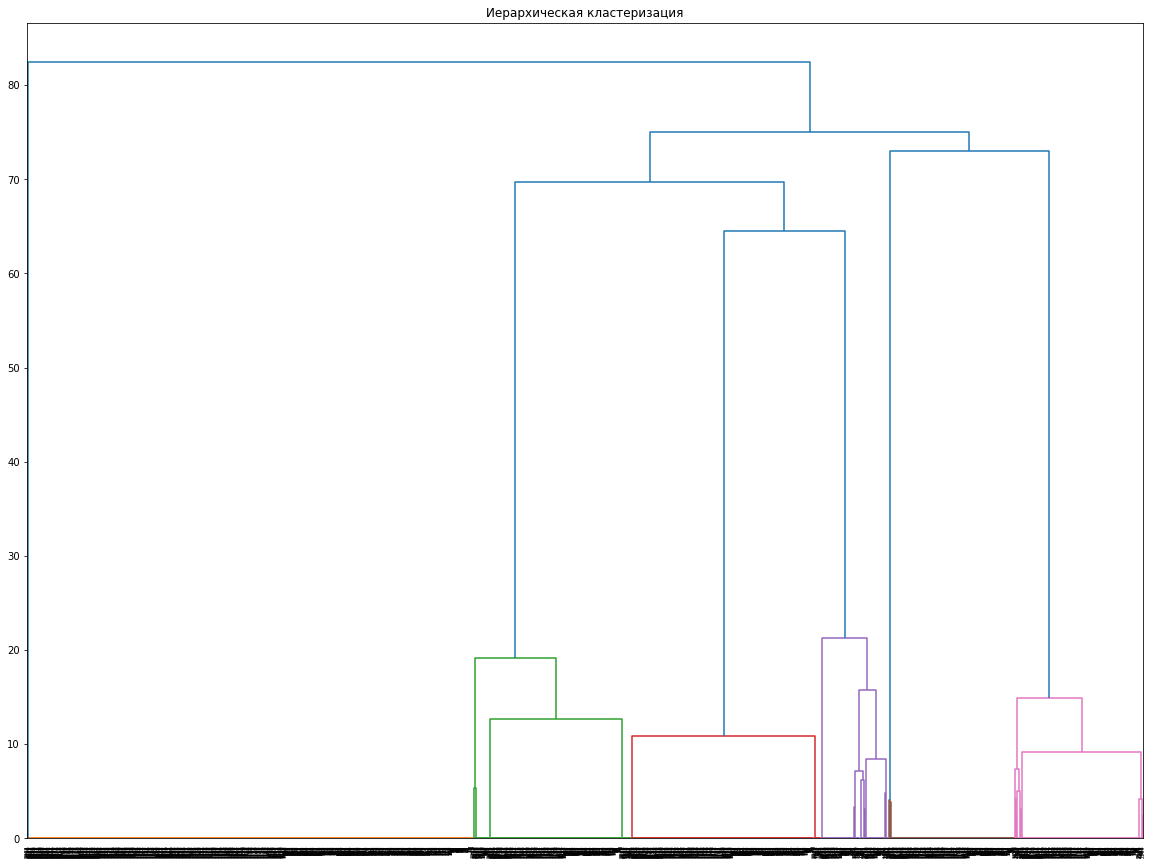

In [31]:
X = data_seg.drop(['customer_id'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(20, 15))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

In [32]:
km = KMeans(n_clusters = 6, random_state = 0)
labels = km.fit_predict(X_st)
data_seg['cluster_km'] = labels

In [33]:
data_seg.groupby('cluster_km').mean()

category,Дача,Дом,Прочее,Рассада,Растения,Сумка
cluster_km,,,,,,
0,0.003663,0.007326,0.003663,0.0,0.003663,1.000000
1,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.073314,1.000000,0.0,0.102639,0.000000
3,0.000000,0.036675,0.000000,0.0,1.000000,0.000000
4,1.000000,0.032727,0.050909,0.0,0.036364,0.007273
5,0.013793,0.124138,0.158621,1.0,0.482759,0.006897


Средние значения говорят о следующем:
1. Кластер 0 активнее всего покупает товары из категории "Сумки";
2. Кластер 1 активнее покупает "Прочее", но есть покупки в "Растениях" и "Доме";
3. Кластер 2 покупает только в категории "Дом";
4. Кластер 3 покупает активнее покупает в категории "Растения", но есть также покупки в "Доме";
5. Кластер 4 покупает товары всех категорий, кроме "Рассады". Больше всего - в "Даче";
6. Кластер 5 покупает во всех категориях. Больше всего в "Растениях", меньше - в "Сумках".

## Статистическая проверка гипотез

Проверим различия средней выручки между сегментом "Растения" и остальными сегментами. Т.к. мы выделили 6 сегментов, будем использовать t-test с поправкой Бонферрони. Сформулируем гипотезы:
- HO. Средная выручка между кластером "Растения" и кластером х равны.
- Н1. Нет оснований утверждать, что средная выручка между кластером x и кластером y равны.

Под кластером х будем считать все прочие кластеры.

Напишем функцию.

In [34]:
def stat(x):
    x_avg_check = data_new.query('category == "Растения"')['total_price']
    y_avg_check = data_new.query('category == @x')['total_price']
    alpha = 0.05 / 5
    results = st.ttest_ind(x_avg_check, y_avg_check)
    print('Сравниваемые категории: "Растения" и "{}"'.format(x))
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    print('')

In [35]:
for i in data_new['category'].unique():
    stat(i)

Сравниваемые категории: "Растения" и "Растения"
p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу

Сравниваемые категории: "Растения" и "Дом"
p-значение: 3.2202122874843053e-142
Отвергаем нулевую гипотезу

Сравниваемые категории: "Растения" и "Дача"
p-значение: 2.590776771509021e-44
Отвергаем нулевую гипотезу

Сравниваемые категории: "Растения" и "Прочее"
p-значение: 8.307656742969329e-48
Отвергаем нулевую гипотезу

Сравниваемые категории: "Растения" и "Сумка"
p-значение: 1.387546601437067e-273
Отвергаем нулевую гипотезу

Сравниваемые категории: "Растения" и "Рассада"
p-значение: 0.0005943145794961427
Отвергаем нулевую гипотезу



Результаты теста Стьюдента показали, что нет оснований считать равными средние выручки между категорией "Растения" и остальными категориями.

## Выводы и рекомендации

Перед нами стояла задача сегментировать пользователей, чтобы выдвинуть персонализированные предложения.

Во время предобработки мы обнаружили 1886 скрытых дубликатов и после консультации с оператором БД удалили их. Мы выяснили, что **количество уникальных пользователей** составляет 2451 человек, **количество уникальных товаров** - 2343 шт., а **средняя выручка** за весь период равна 194 руб.

В датасете также имеются оптовики; самый крупный заказ был сделан на 675 000 руб.

Мы не обнаружили какой-либо сезонности по товарам: во все месяцы покупки совершались приблизительно одинакого (за исключением оптовых покупок, но это исключение).

Затем распределили все товары по 6 категориям: "Дом", "Растения","Дача", "Рассада", "Сумка", "Прочее". Ниже представлено соотношение категорий и количества товаров:
- Растения -    1531
- Дом -         1451
- Прочее -       554
- Рассада -      530
- Дача -         407
- Сумка -        315

Поскольку категория "Прочее" неопределена, посмотрим топ-5 её товаров:
- Контейнер -       13
- Новогоднее -      12
- Нож -             11
- Бальзамин -       10
- Декоративная -     9

После этого мы осуществили иерархическую кластеризацию, выделив 6 кластеров. Результаты следующие:

1. Кластер 0 активнее всего покупает товары из категории "Сумки";
2. Кластер 1 активнее покупает "Прочее", но есть покупки в "Растениях" и "Доме";
3. Кластер 2 покупает только в категории "Дом";
4. Кластер 3 покупает активнее покупает в категории "Растения", но есть также покупки в "Доме";
5. Кластер 4 покупает товары всех категорий, кроме "Рассады". Больше всего - в "Даче";
6. Кластер 5 покупает во всех категориях. Больше всего в "Растениях", меньше - в "Сумках".

Наконец, мы статистически сравнили среднюю выручку между категорией "Растения" и всеми остальными категориями, используя тест Стьюдента с поправкой Бонферрони. Результаты теста показали, что **нет оснований считать, что средная выручка между кластерами равна**.

Основываясь на имеющихся данных, мы можем дать **следующие рекомендации**:
1. Отсутствие сезонности - недоработка. Нужно активно внедрять акции на сезонные товары (например, на категорию "Дача" или "Рассада"). 
2. Предлагать дополнительные товары ("Вас также может заинтересовать..."), основываясь на информации из кластеров. Например, пользователям из кластера 3 предлагать в качестве дополнительных товары из категории "Дом".
3. Провести полную ревизию категорий и рассортировать товары так, чтобы избежать категории "Прочее" (в настоящем проекте это была бы неоправданно трудозатратная задача).

# Дополнительные материалы
* [Дашборд](https://public.tableau.com/app/profile/konstantin2683/viz/final_project_16268018566590/Dashboard1?publish=yes)